In [175]:
import numpy as np
from sklearn.datasets import make_blobs
from collections import defaultdict
import matplotlib.pyplot as plt
from copy import copy
import math
np.random.seed(1337)

In [176]:
def compute_hash_buckets(X, epsilon, t=None):
    """
    Compute LSH hashes and group vectors into hash buckets.

    Args:
        X (ndarray): Input data of shape (n_samples, n_features).
        epsilon (float): Hash grid size parameter.

    Returns:
        dict: Hash buckets with bucket keys and vector indices as values.
    """
    if(t==None):
        t=int(X.shape[0]**0.5)
    
    buckets = defaultdict(list)
    hashes = defaultdict(list)
    for _ in range(t):
        eta = np.random.uniform(0, 2 * epsilon, X.shape[1])
        _hashes = np.floor((X + eta) / (2 * epsilon))
        for i, h in enumerate(_hashes):
            _h=tuple(np.append(h, eta))
            hashes[i].append(_h)
            buckets[_h].append(i)
    
    return buckets, hashes

def create_bucket_graph(buckets, hashes):
    """
    Create a directed graph on hash buckets.

    Args:
        buckets (dict): Hash buckets with vector indices.

    Returns:
        dict: Directed adjacency list where edges are weighted by bucket size.
    """
    graph = defaultdict(dict)
    for u in hashes.keys():
        for bucket_key in hashes[u]:
            for other_bucket_key in hashes[u]:
                if bucket_key == other_bucket_key:
                    continue
                if len(buckets[bucket_key]) > len(buckets[other_bucket_key]):
                    weight = len(buckets[bucket_key])
                    if other_bucket_key not in graph[bucket_key]:
                        graph[bucket_key][other_bucket_key] = weight
    return graph


In [177]:
def prune_graph(graph):
    """
    Prune the graph to retain only maximum weight outgoing edges.

    Args:
        graph (dict): Directed graph adjacency list.

    Returns:
        dict: Pruned undirected adjacency list.
    """
    pruned_graph = defaultdict(set)

    for u in graph:
        max_weight_edge = max(graph[u].items(), key=lambda x: x[1])[0]
        pruned_graph[u].add(max_weight_edge)
        pruned_graph[max_weight_edge].add(u)
    
    return pruned_graph

def get_connected_components(graph):
    """
    Perform DFS to find connected components in an undirected graph.

    Args:
        graph (dict): Undirected adjacency list.

    Returns:
        list: List of connected components as sets of bucket keys.
    """
    visited = set()
    connected_components = []

    def dfs(node, component):
        visited.add(node)
        component.add(node)
        for neighbor in graph[node]:
            if neighbor not in visited:
                dfs(neighbor, component)

    for node in graph:
        if node not in visited:
            component = set()
            dfs(node, component)
            connected_components.append(component)
    
    return connected_components

In [178]:
def quick_shift_clustering(X, epsilon):
    """
    Perform Quick-Shift clustering.

    Args:
        X (ndarray): Input data of shape (n_samples, n_features).
        epsilon (float): Hash grid size parameter.

    Returns:
        list: Clusters as connected components of vectors.
    """
    buckets, hashes = compute_hash_buckets(X, epsilon)
    graph = create_bucket_graph(buckets, hashes)
    pruned_graph = prune_graph(graph)
    connected_components = get_connected_components(pruned_graph)

    clusters = []
    for component in connected_components:
        cluster = []
        for bucket_key in component:
            cluster.extend(buckets[bucket_key])
        clusters.append(cluster)
    
    return clusters

4647
427
7
11


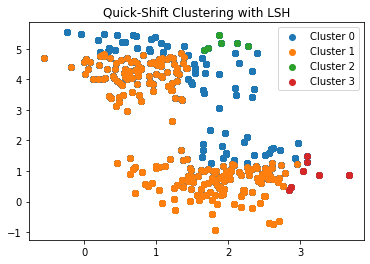

In [179]:
def test_quick_shift():
    X, y = make_blobs(n_samples=300, centers=2, cluster_std=0.60, random_state=0)
    
    # Parameters
    epsilon = 3.0

    # Perform clustering
    clusters = quick_shift_clustering(X, epsilon)
    
    # plt.scatter(X[:, 0], X[:, 1], c='gray', alpha=0.5, label="Data Points")
    for cluster_idx, cluster in enumerate(clusters):
        print(len(cluster))
        cluster_points = X[cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_idx}")
    plt.legend()
    plt.title("Quick-Shift Clustering with LSH")
    plt.show()

test_quick_shift()
